Download data

In [1]:
!pip install fsspec

In [2]:
import fsspec
from pathlib import Path

destination = Path("data")
destination.mkdir(exist_ok=True, parents=True)
fs = fsspec.filesystem("github", org="lorenzovecchietti", repo="FinanceAI")
fs.get(fs.ls("data/"), destination.as_posix())

In [3]:
import os

def concatenate_text_files(folder_path, output_file):
    # List to hold the names of text files
    text_files = [f for f in os.listdir(folder_path) if f.startswith("SPY")]

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for filename in text_files:
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as infile:
                outfile.write(infile.read() + '\n')  # Add newline for separation

# Example usage
folder_path = 'data'  # Replace with your folder path
output_file = 'data/1_min_SPY_2008-2021.csv'  # Output file name
concatenate_text_files(folder_path, output_file)

## Data Preparation

In [4]:
import pandas as pd
df=pd.read_csv("data/1_min_SPY_2008-2021.csv", header=1, names=["","DateTime Stamp", "Open", "High", "Low", "Close", "Volume","Bars", "Average"],usecols=[1,2,3,4,5,6,7,8], index_col=0, parse_dates=[0], date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d  %H:%M:%S'), sep=",")
print(df.head())

<ipython-input-4-14123df96476>:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df=pd.read_csv("data/1_min_SPY_2008-2021.csv", header=1, names=["","DateTime Stamp", "Open", "High", "Low", "Close", "Volume","Bars", "Average"],usecols=[1,2,3,4,5,6,7,8], index_col=0, parse_dates=[0], date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d  %H:%M:%S'), sep=",")


                      Open   High    Low  Close  Volume  Bars  Average
DateTime Stamp                                                        
2009-05-22 07:31:00  89.38  89.53  89.37  89.50    5336  1938   89.468
2009-05-22 07:32:00  89.51  89.54  89.48  89.49    3349  1184   89.516
2009-05-22 07:33:00  89.49  89.49  89.31  89.34    3495  1240   89.386
2009-05-22 07:34:00  89.33  89.46  89.33  89.39    9731  2637   89.379
2009-05-22 07:35:00  89.38  89.41  89.17  89.18    8546  2366   89.273


# Clean Data

In [5]:
df = df[~df.index.duplicated(keep='first')] # remove duplicate rows
df.sort_index(inplace=True) # sort by date

## Check data

Check if there is any missing data

In [6]:
# Difference in seconds
diff_series = df.index.to_series().diff().dt.total_seconds() / 60

# Initialize validity series
validity_series = pd.Series(index=df.index, dtype=bool)

for i in range(1, len(df)):
    if diff_series.iloc[i] != 1: # If difference is not 1 min...
        if df.index[i].date() == df.index[i - 1].date(): # ...and the two dates are the same...
            validity_series.iloc[i] = False # ...then there is some missing data
        else:
            validity_series.iloc[i] = True
    else:
        validity_series.iloc[i] = True
print(validity_series[validity_series==False])

Series([], dtype: bool)


Print data description and plot

In [7]:
print(df.describe())

               Open          High           Low         Close        Volume  \
count  1.432780e+06  1.432780e+06  1.432780e+06  1.432780e+06  1.432780e+06   
mean   2.090919e+02  2.091426e+02  2.090408e+02  2.090919e+02  2.696174e+03   
std    8.407439e+01  8.408176e+01  8.406655e+01  8.407434e+01  3.793733e+03   
min    6.712000e+01  6.720000e+01  6.710000e+01  6.712000e+01  0.000000e+00   
25%    1.330300e+02  1.330600e+02  1.329900e+02  1.330300e+02  6.580000e+02   
50%    2.028400e+02  2.028900e+02  2.027900e+02  2.028400e+02  1.501000e+03   
75%    2.777300e+02  2.778000e+02  2.776600e+02  2.777300e+02  3.263000e+03   
max    4.206700e+02  4.207200e+02  4.204000e+02  4.206700e+02  3.312820e+05   

               Bars       Average  
count  1.432780e+06  1.432780e+06  
mean   8.369606e+02  2.090918e+02  
std    9.674674e+02  8.407419e+01  
min    0.000000e+00  6.715200e+01  
25%    2.770000e+02  1.330280e+02  
50%    5.490000e+02  2.028415e+02  
75%    1.054000e+03  2.777253e+02  


<Axes: xlabel='DateTime Stamp'>

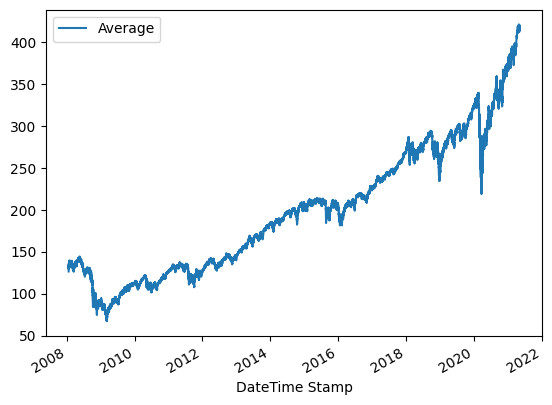

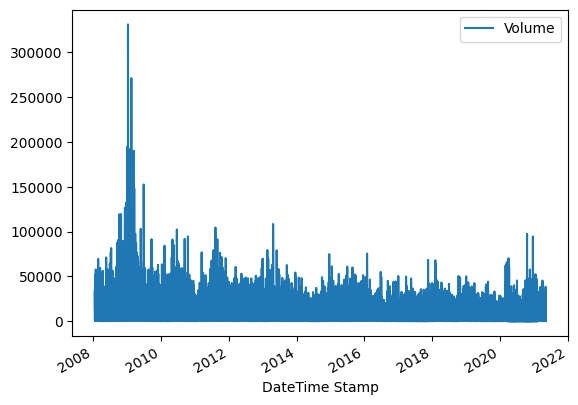

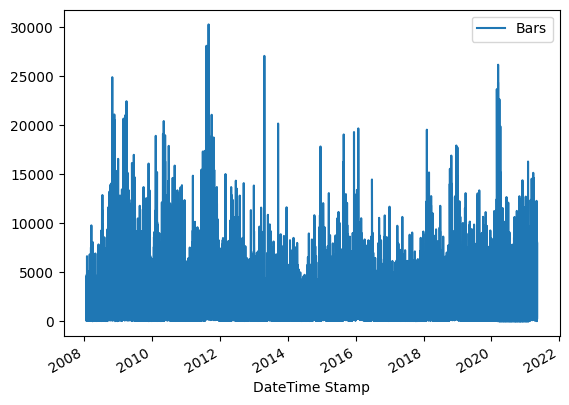

In [8]:
df.plot(y=['Average'])
df.plot(y=['Volume'])
df.plot(y=['Bars'])